# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**:  
They are similar in the sense that they both use shared weights in the network.
They are different because CNNs operate on a fixed-size input and produce a fixed-size output. In contrast to that, RNNs operate on arbitrary-length sequences, output arbitrary-length sequences and preserve the context in the memory over time.

**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**:  
- Exploding gradients:
    - use shrinkage methods for recurrent weights
    - use gradient clipping when the norm exceeds a certain threshold
- Vanishing gradients:
    - use orthogonal initialization of weights
    - use specially designed architectures that solve this problem (e.g. LSTM)

**FEEDBACK**

- Time spent: 15 min
- Useful: yes, to repeat a little bit of theory
- Major problems: none, pretty much straightforward


## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [2]:
from torch.nn.parameter import Parameter
from torch import Tensor, zeros, randn

class LSTMCell(nn.Module):
    """The LSTM layer."""
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # START TODO #############
        # initialize required parameters / layers
        # Forget
        self.W_forget = Parameter(Tensor(self.hidden_size, self.hidden_size + self.input_size))
        self.b_forget = Parameter(Tensor(self.hidden_size))
        # Input
        self.W_input = Parameter(Tensor(self.hidden_size, self.hidden_size + self.input_size))
        self.b_input = Parameter(Tensor(self.hidden_size))
        # Candidate
        self.W_candidate = Parameter(Tensor(self.hidden_size, self.hidden_size + self.input_size))
        self.b_candidate = Parameter(Tensor(self.hidden_size))
        # Output
        self.W_output = Parameter(Tensor(self.hidden_size, self.hidden_size + self.input_size))
        self.b_output = Parameter(Tensor(self.hidden_size))
        
        # Initialization
        stdv = 1. / np.sqrt(self.hidden_size + self.input_size)

        self.W_forget.data.uniform_(-stdv, stdv)
        self.b_forget.data.uniform_(-stdv, stdv)
        
        self.W_input.data.uniform_(-stdv, stdv)
        self.b_input.data.uniform_(-stdv, stdv)
        
        self.W_candidate.data.uniform_(-stdv, stdv)
        self.b_candidate.data.uniform_(-stdv, stdv)
        
        self.W_output.data.uniform_(-stdv, stdv)
        self.b_output.data.uniform_(-stdv, stdv)
        # END TODO #############
        
    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).
                
        Returns:
            Tuple as (output_hidden, new_internal_state).
        """
        if hx is None:
            hx = self._init_hidden_state(x)
        # START TODO #############
        h, C = hx
        h_x_concat = torch.cat([h, x], dim=1)
        # Forget
        forget = torch.sigmoid(
            F.linear(h_x_concat, self.W_forget, self.b_forget)
        )
        # Input
        input = torch.sigmoid(
           F.linear(h_x_concat, self.W_input, self.b_input)
        )
        
        # Candidate
        C_tilde = torch.tanh(
            F.linear(h_x_concat, self.W_candidate, self.b_candidate)
        )
        
        # New internal cell state (C)
        C_new = forget * C + input * C_tilde

        # New hidden state
        o = torch.sigmoid(
            F.linear(h_x_concat, self.W_output, self.b_output)
        )
        h_new = o * torch.tanh(C_new)
        return h_new, C_new
        # END TODO #############
        
    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.
        
        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        # START TODO #############
        batch_size = x.shape[0]
        return (
            torch.zeros(batch_size, self.hidden_size),
            torch.zeros(batch_size, self.hidden_size)
        )
        # END TODO #############

In [3]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""
    
    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.
        
        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.
        
        Returns:
            Tuple as (output_stacked_hidden, (last_hidden_state, last_new_internal_state)).
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)
        # START TODO #############
        outputs = []
        # iterate over the sequence and apply the LSTM
        seq_len, batch_size, input_size = x.shape
        for idx in range(seq_len):
            element = x[idx]
            hx = LSTMCell.forward(self, element, hx)
            last_hidden_state, last_internal_state = hx
            outputs.append(last_hidden_state)

        output_stacked_hidden = torch.stack(outputs, 0)
        return output_stacked_hidden, (last_hidden_state, last_internal_state)
        # END TODO #############

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [4]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)


for epoch in range(101):
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()


epoch: 0, loss:3.537670850753784
test accuracy: 0.03
epoch: 10, loss:0.0758466124534607
test accuracy: 0.11
epoch: 20, loss:0.030180344358086586
test accuracy: 0.32
epoch: 30, loss:0.010651836171746254
test accuracy: 0.37
epoch: 40, loss:0.01499133463948965
test accuracy: 0.49
epoch: 50, loss:0.04671848937869072
test accuracy: 0.11
epoch: 60, loss:0.0029550378676503897
test accuracy: 0.5
epoch: 70, loss:0.0012788170715793967
test accuracy: 0.86
epoch: 80, loss:0.0004979714867658913
test accuracy: 0.95
epoch: 90, loss:0.0002974035160150379
test accuracy: 0.97
epoch: 100, loss:0.0003387029282748699
test accuracy: 0.97


**FEEDBACK**

- Time spent: 8 - 9 h
- Useful: very; nice to see the manually-implemented recurrent architecture on work
- Major problems: whole implementation depends on the weight initialization

The reason we spent so much time on this part is that we were initializing the weights from a normal distribution (mean 0, variance 1). Unfortunately this make the training very unstable and it usually does not converge. The whole time we thought we had bug(s) in other parts. When we returned to the LSTMCell constructor and initialized the weights from the uniform distribution inversely proportional to the size of weight matrices, everything turned out to work fine.

## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

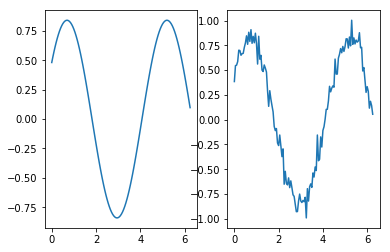

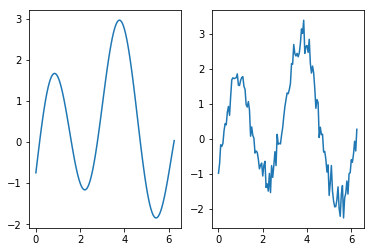

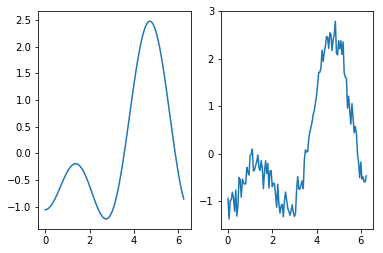

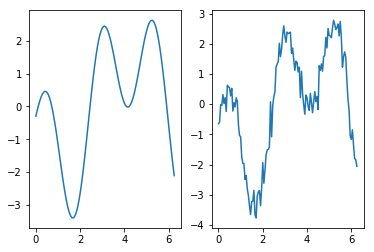

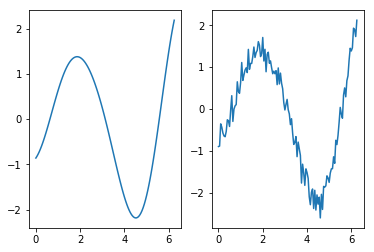

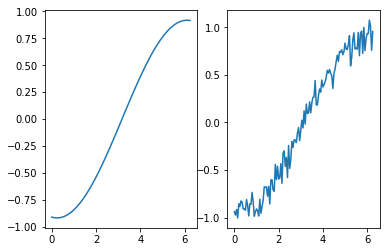

In [5]:
# let's create a generator for sine functions with different amplitudes, shift and frequency

class RandomSineFunction:
    
    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)
        
    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self. frequency, self.offsets)]).sum(axis=0)

    
def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
fs = sample_sine_functions(6)
xs = np.arange(0, 2 * np.pi, 0.05)
for f in fs:
    ys = f(xs)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.subplot(1, 2, 2)
    plt.plot(xs, noisy(ys))
# END TODO #############


Now it's time to define the model! Let's stack two LSTMs both with output shape (sequence_length, batch_size, hidden_size) followed by a Linear layer which takes a (sequence_length, batch_size, hidden_size) vector as input and outputs a tensor with shape (sequence_length, batch_size, 1).


To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [6]:
class NoiseRemovalModel(nn.Module):
    """
    """
    
    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift
        # START TODO #############
        self.lstm1 = LSTM(1, hidden_size)
        self.lstm2 = LSTM(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        # END TODO #############
        
        
    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.
        
        This function
        1) pads the input sequence with self.interval zeros at the end,
        2) applies an LSTM
        3) cuts the first self.interval outputs
        4) applies another LSTM
        5) applies Linear layer.
        
        Args:
            x: The input sequence
        
        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.
        
        # START TODO #############
        # LSTM
        padding = torch.zeros(self.shift, *x.shape[1:])
        x_padded = torch.cat([x, padding], dim=0) # Pad
        output_stacked_hidden, hx = self.lstm1(x_padded)
        
        # LSTM
        x_cut = output_stacked_hidden[self.shift:] # Cut
        output_stacked_hidden, hx = self.lstm2(x_cut, hx)
        
        # Linear
        out = self.linear(output_stacked_hidden)
        return out
        # END TODO #############

In [7]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)


train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)

In [8]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14,3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    
def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                  np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    num_samples = train_sequences.shape[0]
    for epoch in range(num_epochs):
        # START TODO #############
        for batch_idx in range(num_samples // batch_size):
            optimizer.zero_grad()
            batch = noisy_train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            output = model(batch)
            labels = train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            loss = loss_fn(labels, output)
            loss.backward()
            optimizer.step()
        # END TODO #############
        print(f"epoch: {epoch}, train loss:{loss}")
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()


epoch: 0, train loss:350.20855712890625
epoch: 0, validation loss:1446.3985595703125


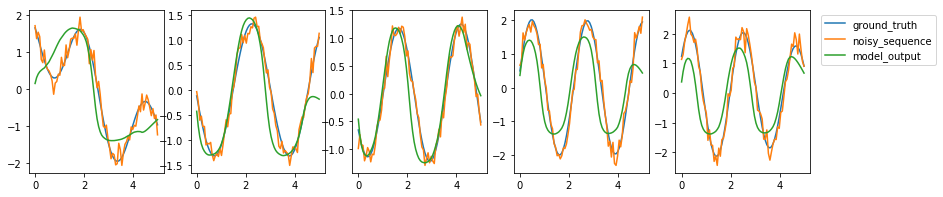

-285.7553% of noise removed.
epoch: 1, train loss:295.5116271972656
epoch: 1, validation loss:1095.7362060546875
epoch: 2, train loss:231.49411010742188
epoch: 2, validation loss:992.4205932617188
epoch: 3, train loss:162.75448608398438
epoch: 3, validation loss:648.1129760742188
epoch: 4, train loss:141.8347930908203
epoch: 4, validation loss:527.5888671875
epoch: 5, train loss:93.54592895507812
epoch: 5, validation loss:336.3229064941406
epoch: 6, train loss:73.01546478271484
epoch: 6, validation loss:270.20440673828125
epoch: 7, train loss:94.1480712890625
epoch: 7, validation loss:336.58306884765625
epoch: 8, train loss:52.229347229003906
epoch: 8, validation loss:226.81900024414062
epoch: 9, train loss:43.3206787109375
epoch: 9, validation loss:171.2789306640625
epoch: 10, train loss:37.76648712158203
epoch: 10, validation loss:177.47177124023438


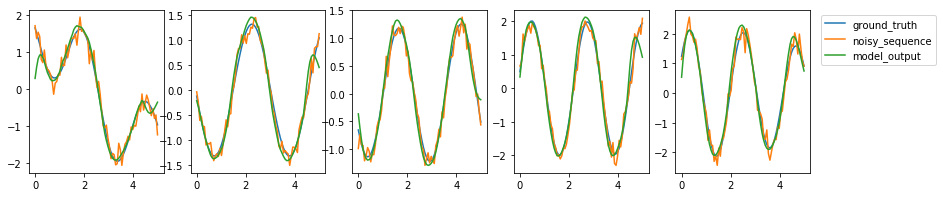

-2.4078% of noise removed.
epoch: 11, train loss:36.18794250488281
epoch: 11, validation loss:145.90220642089844
epoch: 12, train loss:37.0025520324707
epoch: 12, validation loss:135.44248962402344
epoch: 13, train loss:31.777084350585938
epoch: 13, validation loss:134.18873596191406
epoch: 14, train loss:34.17766189575195
epoch: 14, validation loss:158.89614868164062
epoch: 15, train loss:32.26012420654297
epoch: 15, validation loss:149.12574768066406
epoch: 16, train loss:25.689918518066406
epoch: 16, validation loss:149.84788513183594
epoch: 17, train loss:27.259143829345703
epoch: 17, validation loss:153.85946655273438
epoch: 18, train loss:27.356800079345703
epoch: 18, validation loss:113.1407470703125
epoch: 19, train loss:21.212827682495117
epoch: 19, validation loss:119.26248168945312
epoch: 20, train loss:23.08140754699707
epoch: 20, validation loss:118.90303039550781


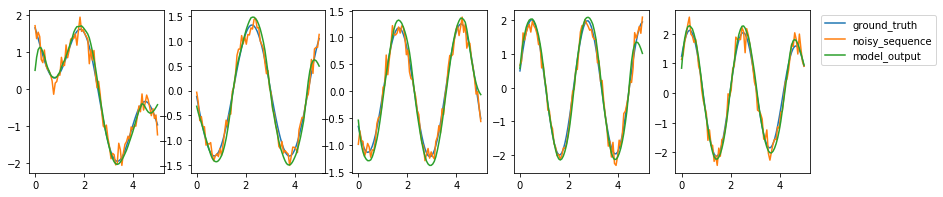

5.7641% of noise removed.
epoch: 21, train loss:22.056577682495117
epoch: 21, validation loss:109.58985137939453
epoch: 22, train loss:20.785900115966797
epoch: 22, validation loss:108.08612060546875
epoch: 23, train loss:20.784286499023438
epoch: 23, validation loss:112.01055908203125
epoch: 24, train loss:22.899890899658203
epoch: 24, validation loss:112.27837371826172
epoch: 25, train loss:21.37864112854004
epoch: 25, validation loss:112.866943359375
epoch: 26, train loss:21.85922622680664
epoch: 26, validation loss:112.99717712402344
epoch: 27, train loss:20.55243492126465
epoch: 27, validation loss:117.60987854003906
epoch: 28, train loss:20.349851608276367
epoch: 28, validation loss:114.07496643066406
epoch: 29, train loss:21.511014938354492
epoch: 29, validation loss:99.2357177734375
epoch: 30, train loss:15.42541217803955
epoch: 30, validation loss:87.04297637939453


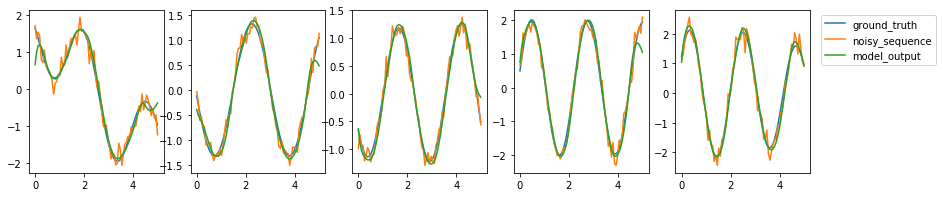

27.5471% of noise removed.
epoch: 31, train loss:16.339916229248047
epoch: 31, validation loss:95.82598114013672
epoch: 32, train loss:16.822317123413086
epoch: 32, validation loss:84.89106750488281
epoch: 33, train loss:15.551900863647461
epoch: 33, validation loss:92.7147216796875
epoch: 34, train loss:16.533340454101562
epoch: 34, validation loss:131.3128662109375
epoch: 35, train loss:19.976280212402344
epoch: 35, validation loss:105.17933654785156
epoch: 36, train loss:14.693578720092773
epoch: 36, validation loss:89.97736358642578
epoch: 37, train loss:15.696843147277832
epoch: 37, validation loss:78.24981689453125
epoch: 38, train loss:12.806614875793457
epoch: 38, validation loss:81.47676086425781
epoch: 39, train loss:13.659248352050781
epoch: 39, validation loss:73.18681335449219
epoch: 40, train loss:11.740945816040039
epoch: 40, validation loss:79.0954818725586


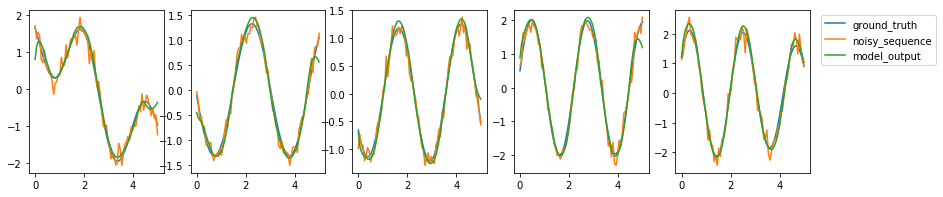

28.6981% of noise removed.
epoch: 41, train loss:12.64786434173584
epoch: 41, validation loss:75.28067779541016
epoch: 42, train loss:11.676689147949219
epoch: 42, validation loss:72.57927703857422
epoch: 43, train loss:12.111085891723633
epoch: 43, validation loss:70.54898071289062
epoch: 44, train loss:11.319967269897461
epoch: 44, validation loss:68.6355972290039
epoch: 45, train loss:11.906597137451172
epoch: 45, validation loss:67.8400650024414
epoch: 46, train loss:11.070033073425293
epoch: 46, validation loss:67.37326049804688
epoch: 47, train loss:11.694816589355469
epoch: 47, validation loss:66.75497436523438
epoch: 48, train loss:11.064556121826172
epoch: 48, validation loss:66.69368743896484
epoch: 49, train loss:11.345036506652832
epoch: 49, validation loss:66.40248107910156
epoch: 50, train loss:11.086812973022461
epoch: 50, validation loss:66.04334259033203


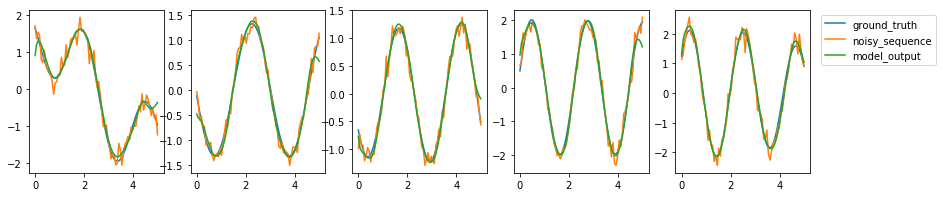

38.4587% of noise removed.
epoch: 51, train loss:11.285103797912598
epoch: 51, validation loss:66.10269927978516
epoch: 52, train loss:11.087068557739258
epoch: 52, validation loss:65.29256439208984
epoch: 53, train loss:11.646395683288574
epoch: 53, validation loss:65.7185287475586
epoch: 54, train loss:11.951711654663086
epoch: 54, validation loss:65.49653625488281
epoch: 55, train loss:13.212845802307129
epoch: 55, validation loss:68.74644470214844
epoch: 56, train loss:14.799898147583008
epoch: 56, validation loss:73.89043426513672
epoch: 57, train loss:17.387741088867188
epoch: 57, validation loss:87.62450408935547
epoch: 58, train loss:18.847000122070312
epoch: 58, validation loss:106.36675262451172
epoch: 59, train loss:16.305912017822266
epoch: 59, validation loss:117.19136810302734
epoch: 60, train loss:10.073217391967773
epoch: 60, validation loss:96.39849853515625


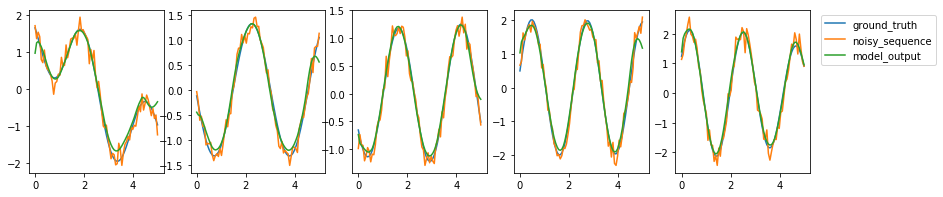

16.3007% of noise removed.
epoch: 61, train loss:9.006150245666504
epoch: 61, validation loss:64.4334716796875
epoch: 62, train loss:11.68326473236084
epoch: 62, validation loss:63.196590423583984
epoch: 63, train loss:9.588054656982422
epoch: 63, validation loss:70.39375305175781
epoch: 64, train loss:7.826486587524414
epoch: 64, validation loss:58.80160140991211
epoch: 65, train loss:7.885554313659668
epoch: 65, validation loss:58.549625396728516
epoch: 66, train loss:7.799224376678467
epoch: 66, validation loss:56.58172607421875
epoch: 67, train loss:8.123092651367188
epoch: 67, validation loss:57.02496337890625
epoch: 68, train loss:7.59792423248291
epoch: 68, validation loss:55.619998931884766
epoch: 69, train loss:7.469615459442139
epoch: 69, validation loss:54.653419494628906
epoch: 70, train loss:7.455327033996582
epoch: 70, validation loss:54.26747131347656


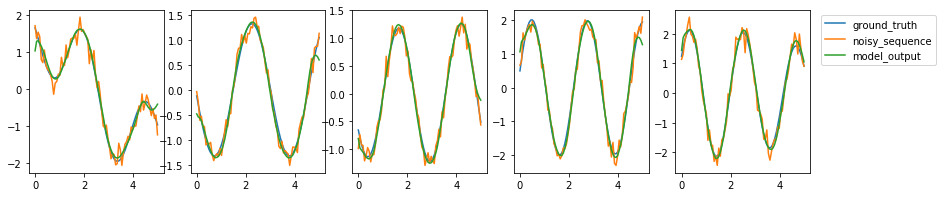

43.3530% of noise removed.
epoch: 71, train loss:7.392292022705078
epoch: 71, validation loss:54.38492202758789
epoch: 72, train loss:7.360321044921875
epoch: 72, validation loss:53.81639862060547
epoch: 73, train loss:7.402864456176758
epoch: 73, validation loss:53.39704513549805
epoch: 74, train loss:7.539470672607422
epoch: 74, validation loss:53.11732864379883
epoch: 75, train loss:7.752091884613037
epoch: 75, validation loss:52.88032913208008
epoch: 76, train loss:7.942941665649414
epoch: 76, validation loss:53.0893440246582
epoch: 77, train loss:7.803584098815918
epoch: 77, validation loss:53.3444709777832
epoch: 78, train loss:7.336703300476074
epoch: 78, validation loss:52.7419548034668
epoch: 79, train loss:7.0392746925354
epoch: 79, validation loss:51.7889289855957
epoch: 80, train loss:6.99594259262085
epoch: 80, validation loss:51.45947265625


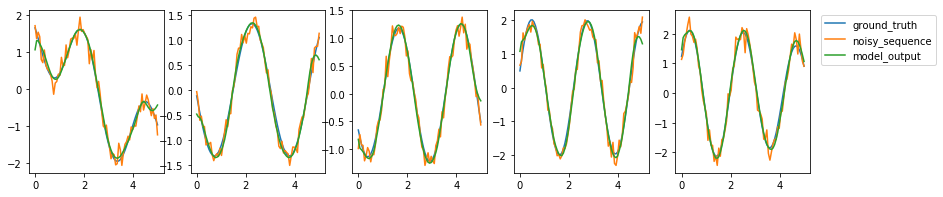

44.6395% of noise removed.
epoch: 81, train loss:7.162117004394531
epoch: 81, validation loss:51.212860107421875
epoch: 82, train loss:7.211583614349365
epoch: 82, validation loss:51.31058120727539
epoch: 83, train loss:7.047917366027832
epoch: 83, validation loss:51.13554763793945
epoch: 84, train loss:7.027790546417236
epoch: 84, validation loss:50.95780944824219
epoch: 85, train loss:7.0518622398376465
epoch: 85, validation loss:50.83142852783203
epoch: 86, train loss:6.988460540771484
epoch: 86, validation loss:50.68955993652344
epoch: 87, train loss:6.995599746704102
epoch: 87, validation loss:50.63032913208008
epoch: 88, train loss:6.972567081451416
epoch: 88, validation loss:50.54787826538086
epoch: 89, train loss:6.967604160308838
epoch: 89, validation loss:50.477420806884766
epoch: 90, train loss:6.951311111450195
epoch: 90, validation loss:50.4137077331543


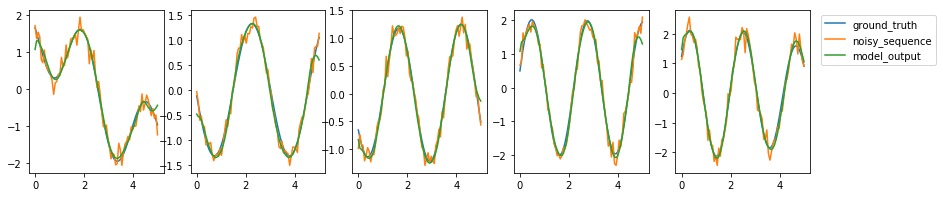

45.2563% of noise removed.
epoch: 91, train loss:6.946048259735107
epoch: 91, validation loss:50.36750411987305
epoch: 92, train loss:6.936128616333008
epoch: 92, validation loss:50.32347869873047
epoch: 93, train loss:6.929872035980225
epoch: 93, validation loss:50.28974914550781
epoch: 94, train loss:6.924959659576416
epoch: 94, validation loss:50.26245880126953
epoch: 95, train loss:6.920132160186768
epoch: 95, validation loss:50.24049758911133
epoch: 96, train loss:6.916476726531982
epoch: 96, validation loss:50.22435760498047
epoch: 97, train loss:6.913879871368408
epoch: 97, validation loss:50.21316909790039
epoch: 98, train loss:6.911984443664551
epoch: 98, validation loss:50.205909729003906
epoch: 99, train loss:6.9106597900390625
epoch: 99, validation loss:50.20174789428711
epoch: 100, train loss:6.909832954406738
epoch: 100, validation loss:50.199851989746094


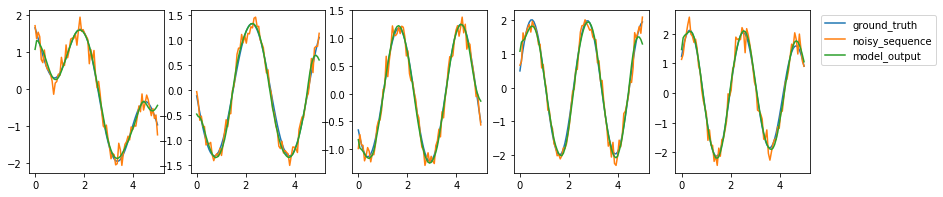

45.3420% of noise removed.


In [9]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

| configuration        | Noise removed in percent |
| -------------------- | --------------------------: |
| initial configuration | 45.3420% |
| configuration 1 | 51.8439% |
| configuration 2 | 48.3923% | 
| configuration 3 | 48.9014% |

epoch: 0, train loss:1242.6734619140625
epoch: 0, validation loss:2069.983154296875


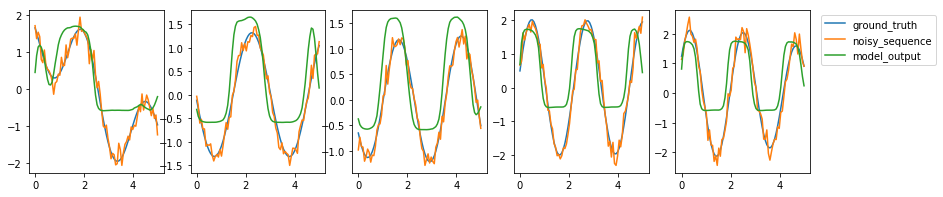

-331.3992% of noise removed.
epoch: 1, train loss:1169.191162109375
epoch: 1, validation loss:2814.530029296875
epoch: 2, train loss:846.6818237304688
epoch: 2, validation loss:1630.16650390625
epoch: 3, train loss:617.1796264648438
epoch: 3, validation loss:849.928955078125
epoch: 4, train loss:281.6392517089844
epoch: 4, validation loss:969.5885620117188
epoch: 5, train loss:278.373291015625
epoch: 5, validation loss:593.75732421875
epoch: 6, train loss:186.89385986328125
epoch: 6, validation loss:389.31451416015625
epoch: 7, train loss:134.536865234375
epoch: 7, validation loss:388.19091796875
epoch: 8, train loss:172.9757843017578
epoch: 8, validation loss:310.19305419921875
epoch: 9, train loss:152.6581573486328
epoch: 9, validation loss:327.4938659667969
epoch: 10, train loss:94.71656799316406
epoch: 10, validation loss:241.54098510742188


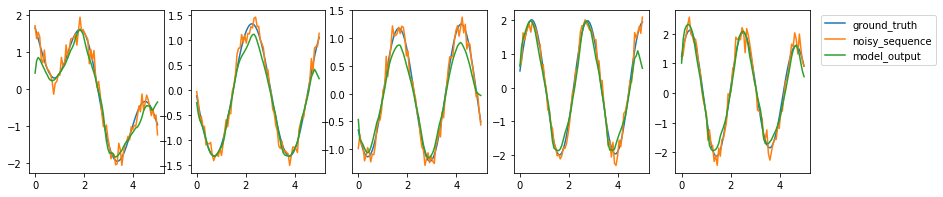

-38.0115% of noise removed.
epoch: 11, train loss:88.21085357666016
epoch: 11, validation loss:178.52401733398438
epoch: 12, train loss:63.45207214355469
epoch: 12, validation loss:183.3746337890625
epoch: 13, train loss:46.79801559448242
epoch: 13, validation loss:118.63025665283203
epoch: 14, train loss:47.049320220947266
epoch: 14, validation loss:108.97586059570312
epoch: 15, train loss:33.719425201416016
epoch: 15, validation loss:101.21709442138672
epoch: 16, train loss:28.897947311401367
epoch: 16, validation loss:84.1695556640625
epoch: 17, train loss:26.06937026977539
epoch: 17, validation loss:80.75311279296875
epoch: 18, train loss:24.934864044189453
epoch: 18, validation loss:69.77727508544922
epoch: 19, train loss:22.29045867919922
epoch: 19, validation loss:69.99153900146484
epoch: 20, train loss:20.806669235229492
epoch: 20, validation loss:64.02043151855469


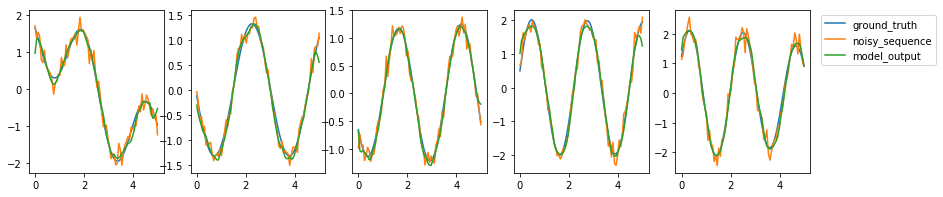

36.2644% of noise removed.
epoch: 21, train loss:18.695362091064453
epoch: 21, validation loss:62.30245590209961
epoch: 22, train loss:17.104576110839844
epoch: 22, validation loss:63.10830307006836
epoch: 23, train loss:18.00089454650879
epoch: 23, validation loss:57.777305603027344
epoch: 24, train loss:18.473167419433594
epoch: 24, validation loss:56.49690628051758
epoch: 25, train loss:16.58112144470215
epoch: 25, validation loss:55.30435562133789
epoch: 26, train loss:13.851607322692871
epoch: 26, validation loss:51.709449768066406
epoch: 27, train loss:14.475687980651855
epoch: 27, validation loss:56.13511657714844
epoch: 28, train loss:15.591517448425293
epoch: 28, validation loss:52.67028045654297
epoch: 29, train loss:18.092025756835938
epoch: 29, validation loss:54.62891387939453
epoch: 30, train loss:16.550500869750977
epoch: 30, validation loss:49.97438049316406


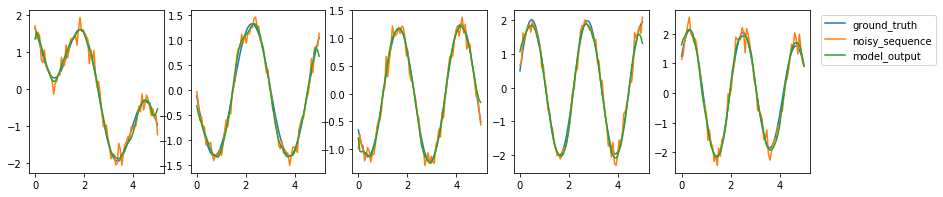

38.0842% of noise removed.
epoch: 31, train loss:15.051841735839844
epoch: 31, validation loss:47.57373046875
epoch: 32, train loss:13.316679000854492
epoch: 32, validation loss:45.618438720703125
epoch: 33, train loss:12.2578125
epoch: 33, validation loss:47.34344482421875
epoch: 34, train loss:11.82125473022461
epoch: 34, validation loss:48.49085235595703
epoch: 35, train loss:12.523892402648926
epoch: 35, validation loss:49.712181091308594
epoch: 36, train loss:11.845972061157227
epoch: 36, validation loss:47.9130744934082
epoch: 37, train loss:12.925684928894043
epoch: 37, validation loss:45.72730255126953
epoch: 38, train loss:12.347882270812988
epoch: 38, validation loss:41.966339111328125
epoch: 39, train loss:13.14422607421875
epoch: 39, validation loss:41.330753326416016
epoch: 40, train loss:11.708626747131348
epoch: 40, validation loss:39.46903610229492


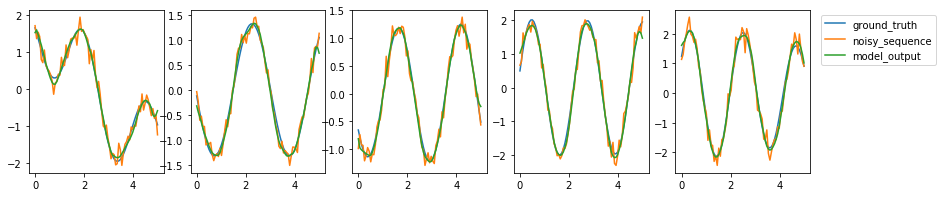

47.1244% of noise removed.
epoch: 41, train loss:10.918249130249023
epoch: 41, validation loss:42.569679260253906
epoch: 42, train loss:10.727924346923828
epoch: 42, validation loss:40.2523193359375
epoch: 43, train loss:11.071464538574219
epoch: 43, validation loss:44.109378814697266
epoch: 44, train loss:11.255955696105957
epoch: 44, validation loss:38.819725036621094
epoch: 45, train loss:11.61656379699707
epoch: 45, validation loss:43.87122344970703
epoch: 46, train loss:11.57720947265625
epoch: 46, validation loss:38.688289642333984
epoch: 47, train loss:11.357269287109375
epoch: 47, validation loss:46.04697799682617
epoch: 48, train loss:10.704610824584961
epoch: 48, validation loss:39.965721130371094
epoch: 49, train loss:10.597189903259277
epoch: 49, validation loss:44.23470687866211
epoch: 50, train loss:10.32259750366211
epoch: 50, validation loss:37.36907196044922


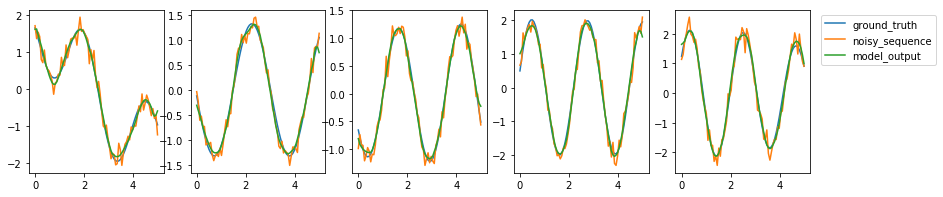

46.5044% of noise removed.
epoch: 51, train loss:10.397834777832031
epoch: 51, validation loss:40.12556838989258
epoch: 52, train loss:10.072977066040039
epoch: 52, validation loss:34.68731689453125
epoch: 53, train loss:9.75574016571045
epoch: 53, validation loss:38.31917953491211
epoch: 54, train loss:10.094595909118652
epoch: 54, validation loss:33.56187438964844
epoch: 55, train loss:9.746376991271973
epoch: 55, validation loss:37.78437423706055
epoch: 56, train loss:9.530232429504395
epoch: 56, validation loss:32.684268951416016
epoch: 57, train loss:8.914876937866211
epoch: 57, validation loss:37.2861213684082
epoch: 58, train loss:8.69046688079834
epoch: 58, validation loss:32.48359680175781
epoch: 59, train loss:8.408207893371582
epoch: 59, validation loss:36.20217514038086
epoch: 60, train loss:8.200643539428711
epoch: 60, validation loss:31.763837814331055


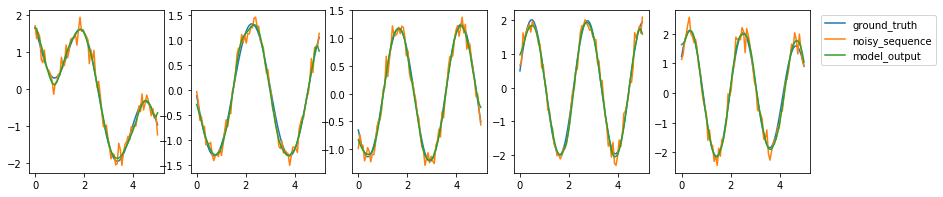

51.0675% of noise removed.
epoch: 61, train loss:7.990993976593018
epoch: 61, validation loss:34.28553009033203
epoch: 62, train loss:7.855569839477539
epoch: 62, validation loss:31.348453521728516
epoch: 63, train loss:7.890537261962891
epoch: 63, validation loss:32.37894821166992
epoch: 64, train loss:7.756242275238037
epoch: 64, validation loss:31.524425506591797
epoch: 65, train loss:7.752487659454346
epoch: 65, validation loss:31.384695053100586
epoch: 66, train loss:7.6842241287231445
epoch: 66, validation loss:31.930660247802734
epoch: 67, train loss:7.64587926864624
epoch: 67, validation loss:31.059049606323242
epoch: 68, train loss:7.598419189453125
epoch: 68, validation loss:31.514314651489258
epoch: 69, train loss:7.543650150299072
epoch: 69, validation loss:31.234649658203125
epoch: 70, train loss:7.549707889556885
epoch: 70, validation loss:30.988813400268555


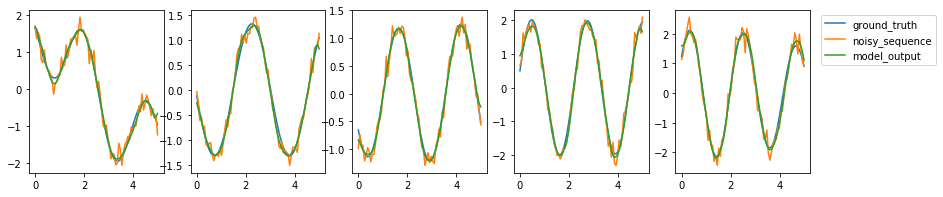

51.3353% of noise removed.
epoch: 71, train loss:7.492088794708252
epoch: 71, validation loss:31.21941375732422
epoch: 72, train loss:7.472720146179199
epoch: 72, validation loss:30.941659927368164
epoch: 73, train loss:7.459019184112549
epoch: 73, validation loss:30.873720169067383
epoch: 74, train loss:7.417506217956543
epoch: 74, validation loss:30.976943969726562
epoch: 75, train loss:7.417360305786133
epoch: 75, validation loss:30.777992248535156
epoch: 76, train loss:7.380572319030762
epoch: 76, validation loss:30.770320892333984
epoch: 77, train loss:7.377024173736572
epoch: 77, validation loss:30.772268295288086
epoch: 78, train loss:7.349202632904053
epoch: 78, validation loss:30.70509147644043
epoch: 79, train loss:7.342263221740723
epoch: 79, validation loss:30.64472007751465
epoch: 80, train loss:7.32314395904541
epoch: 80, validation loss:30.65053367614746


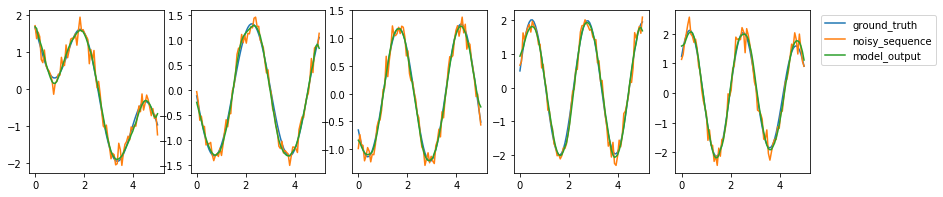

51.6116% of noise removed.
epoch: 81, train loss:7.314111232757568
epoch: 81, validation loss:30.616531372070312
epoch: 82, train loss:7.299764633178711
epoch: 82, validation loss:30.580020904541016
epoch: 83, train loss:7.2901530265808105
epoch: 83, validation loss:30.549678802490234
epoch: 84, train loss:7.281105995178223
epoch: 84, validation loss:30.54009246826172
epoch: 85, train loss:7.270895004272461
epoch: 85, validation loss:30.524770736694336
epoch: 86, train loss:7.263980865478516
epoch: 86, validation loss:30.501319885253906
epoch: 87, train loss:7.256420612335205
epoch: 87, validation loss:30.483983993530273
epoch: 88, train loss:7.249770164489746
epoch: 88, validation loss:30.471044540405273
epoch: 89, train loss:7.244682312011719
epoch: 89, validation loss:30.460590362548828
epoch: 90, train loss:7.239692687988281
epoch: 90, validation loss:30.452070236206055


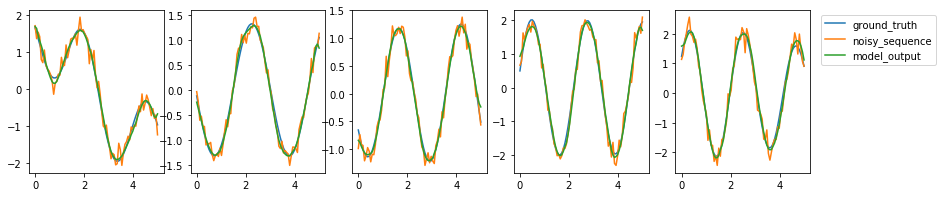

51.8049% of noise removed.
epoch: 91, train loss:7.235029220581055
epoch: 91, validation loss:30.44379997253418
epoch: 92, train loss:7.231261730194092
epoch: 92, validation loss:30.435659408569336
epoch: 93, train loss:7.228205680847168
epoch: 93, validation loss:30.428646087646484
epoch: 94, train loss:7.225573539733887
epoch: 94, validation loss:30.423229217529297
epoch: 95, train loss:7.223310947418213
epoch: 95, validation loss:30.41921043395996
epoch: 96, train loss:7.22145938873291
epoch: 96, validation loss:30.416227340698242
epoch: 97, train loss:7.220007419586182
epoch: 97, validation loss:30.41407012939453
epoch: 98, train loss:7.21890926361084
epoch: 98, validation loss:30.412593841552734
epoch: 99, train loss:7.218110084533691
epoch: 99, validation loss:30.41170883178711
epoch: 100, train loss:7.217567443847656
epoch: 100, validation loss:30.411285400390625


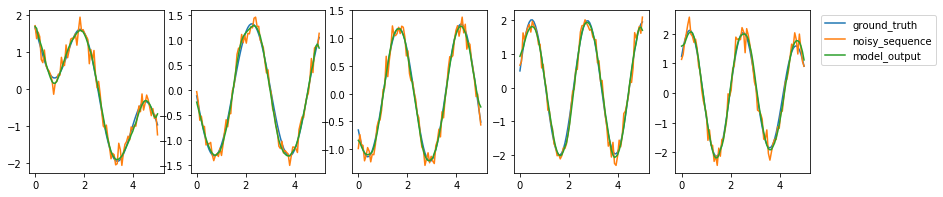

51.8439% of noise removed.
epoch: 0, train loss:282.99566650390625
epoch: 0, validation loss:1569.4659423828125


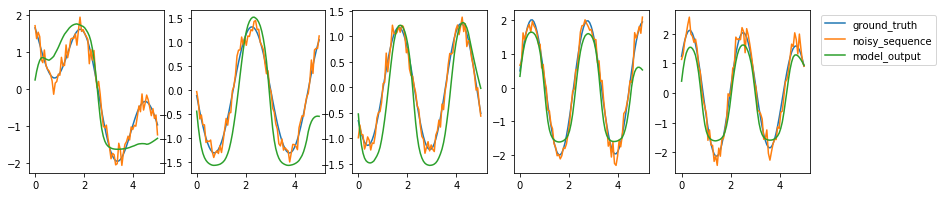

-325.0133% of noise removed.
epoch: 1, train loss:227.2634735107422
epoch: 1, validation loss:988.1536254882812
epoch: 2, train loss:139.7020263671875
epoch: 2, validation loss:550.09765625
epoch: 3, train loss:113.7911605834961
epoch: 3, validation loss:422.19183349609375
epoch: 4, train loss:93.84220123291016
epoch: 4, validation loss:403.8226013183594
epoch: 5, train loss:73.65617370605469
epoch: 5, validation loss:395.48052978515625
epoch: 6, train loss:66.0442123413086
epoch: 6, validation loss:367.3930358886719
epoch: 7, train loss:63.685142517089844
epoch: 7, validation loss:335.333984375
epoch: 8, train loss:67.31958770751953
epoch: 8, validation loss:303.1229248046875
epoch: 9, train loss:61.6504020690918
epoch: 9, validation loss:292.8313293457031
epoch: 10, train loss:45.2164306640625
epoch: 10, validation loss:243.55641174316406


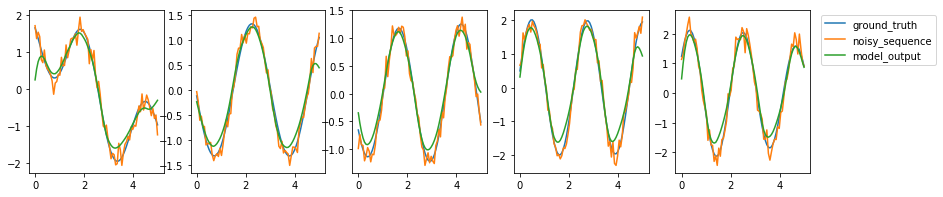

-22.5441% of noise removed.
epoch: 11, train loss:33.33747863769531
epoch: 11, validation loss:168.0785369873047
epoch: 12, train loss:29.582263946533203
epoch: 12, validation loss:129.9042510986328
epoch: 13, train loss:25.68056297302246
epoch: 13, validation loss:116.4506607055664
epoch: 14, train loss:26.713350296020508
epoch: 14, validation loss:104.46656036376953
epoch: 15, train loss:22.285253524780273
epoch: 15, validation loss:98.8358383178711
epoch: 16, train loss:20.62995147705078
epoch: 16, validation loss:93.35968780517578
epoch: 17, train loss:19.733667373657227
epoch: 17, validation loss:90.18376922607422
epoch: 18, train loss:20.18315315246582
epoch: 18, validation loss:88.59386444091797
epoch: 19, train loss:23.206031799316406
epoch: 19, validation loss:84.54457092285156
epoch: 20, train loss:23.13697624206543
epoch: 20, validation loss:82.43077087402344


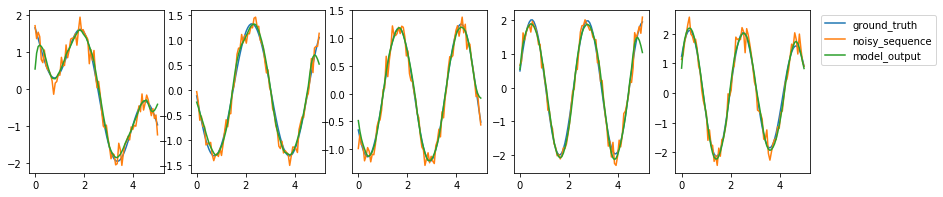

31.1902% of noise removed.
epoch: 21, train loss:17.090587615966797
epoch: 21, validation loss:79.40077209472656
epoch: 22, train loss:17.458759307861328
epoch: 22, validation loss:86.71216583251953
epoch: 23, train loss:18.41179656982422
epoch: 23, validation loss:89.70783996582031
epoch: 24, train loss:23.374553680419922
epoch: 24, validation loss:83.72930145263672
epoch: 25, train loss:15.44780445098877
epoch: 25, validation loss:80.33785247802734
epoch: 26, train loss:19.785680770874023
epoch: 26, validation loss:88.50146484375
epoch: 27, train loss:17.048185348510742
epoch: 27, validation loss:75.6418228149414
epoch: 28, train loss:13.637126922607422
epoch: 28, validation loss:72.28709411621094
epoch: 29, train loss:14.891843795776367
epoch: 29, validation loss:65.77635192871094
epoch: 30, train loss:12.94861125946045
epoch: 30, validation loss:65.4356689453125


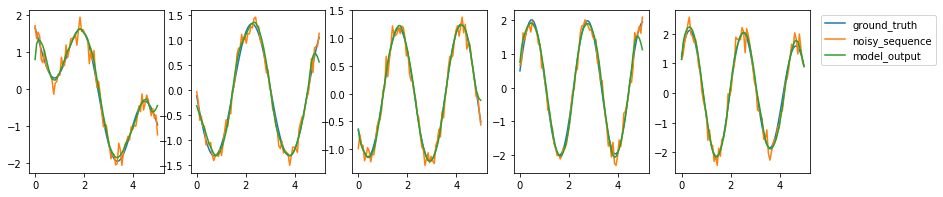

36.0896% of noise removed.
epoch: 31, train loss:13.872345924377441
epoch: 31, validation loss:64.89395904541016
epoch: 32, train loss:13.801772117614746
epoch: 32, validation loss:62.54304504394531
epoch: 33, train loss:12.867449760437012
epoch: 33, validation loss:61.081321716308594
epoch: 34, train loss:12.599372863769531
epoch: 34, validation loss:60.772613525390625
epoch: 35, train loss:13.131112098693848
epoch: 35, validation loss:60.24034118652344
epoch: 36, train loss:12.333640098571777
epoch: 36, validation loss:60.89624786376953
epoch: 37, train loss:11.584461212158203
epoch: 37, validation loss:62.085609436035156
epoch: 38, train loss:12.883247375488281
epoch: 38, validation loss:62.19772720336914
epoch: 39, train loss:13.218628883361816
epoch: 39, validation loss:65.40257263183594
epoch: 40, train loss:11.137593269348145
epoch: 40, validation loss:66.39842224121094


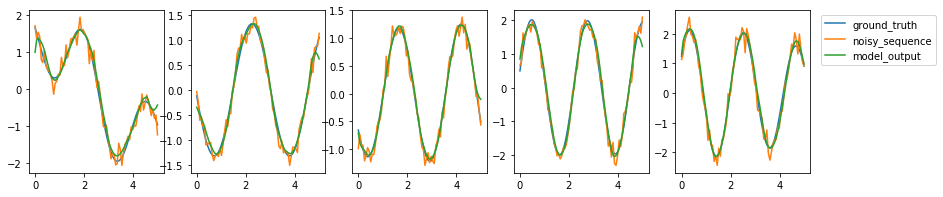

29.8345% of noise removed.
epoch: 41, train loss:12.137479782104492
epoch: 41, validation loss:64.89797973632812
epoch: 42, train loss:14.293381690979004
epoch: 42, validation loss:65.12810516357422
epoch: 43, train loss:10.030289649963379
epoch: 43, validation loss:59.52074432373047
epoch: 44, train loss:11.692682266235352
epoch: 44, validation loss:72.06900787353516
epoch: 45, train loss:15.12917709350586
epoch: 45, validation loss:70.27200317382812
epoch: 46, train loss:9.972006797790527
epoch: 46, validation loss:57.212276458740234
epoch: 47, train loss:11.892829895019531
epoch: 47, validation loss:62.076133728027344
epoch: 48, train loss:12.000986099243164
epoch: 48, validation loss:61.518836975097656
epoch: 49, train loss:12.19732666015625
epoch: 49, validation loss:65.31583404541016
epoch: 50, train loss:12.495013236999512
epoch: 50, validation loss:69.31024932861328


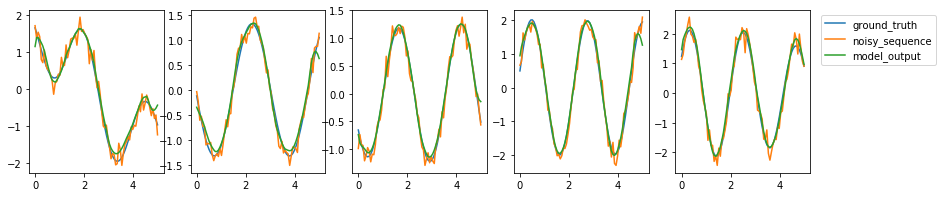

25.1658% of noise removed.
epoch: 51, train loss:15.095358848571777
epoch: 51, validation loss:71.8979721069336
epoch: 52, train loss:14.567838668823242
epoch: 52, validation loss:82.63922119140625
epoch: 53, train loss:13.952964782714844
epoch: 53, validation loss:91.55795288085938
epoch: 54, train loss:12.514826774597168
epoch: 54, validation loss:87.27615356445312
epoch: 55, train loss:8.898685455322266
epoch: 55, validation loss:75.32593536376953
epoch: 56, train loss:7.627399444580078
epoch: 56, validation loss:60.799110412597656
epoch: 57, train loss:8.736286163330078
epoch: 57, validation loss:50.53192138671875
epoch: 58, train loss:9.493873596191406
epoch: 58, validation loss:51.76201629638672
epoch: 59, train loss:8.782183647155762
epoch: 59, validation loss:52.418094635009766
epoch: 60, train loss:7.789819240570068
epoch: 60, validation loss:49.401161193847656


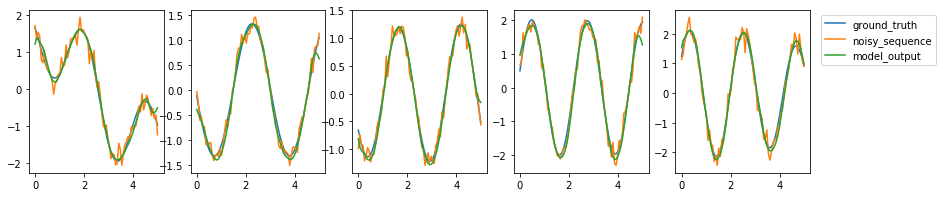

42.3500% of noise removed.
epoch: 61, train loss:7.161388397216797
epoch: 61, validation loss:46.24077224731445
epoch: 62, train loss:6.899787902832031
epoch: 62, validation loss:44.66252517700195
epoch: 63, train loss:6.997110843658447
epoch: 63, validation loss:44.72545623779297
epoch: 64, train loss:7.02269983291626
epoch: 64, validation loss:45.71296310424805
epoch: 65, train loss:7.055869102478027
epoch: 65, validation loss:45.63637924194336
epoch: 66, train loss:6.946534156799316
epoch: 66, validation loss:44.770347595214844
epoch: 67, train loss:6.737404823303223
epoch: 67, validation loss:44.02693557739258
epoch: 68, train loss:6.606367111206055
epoch: 68, validation loss:43.127174377441406
epoch: 69, train loss:6.547050476074219
epoch: 69, validation loss:42.683815002441406
epoch: 70, train loss:6.511760234832764
epoch: 70, validation loss:43.07295608520508


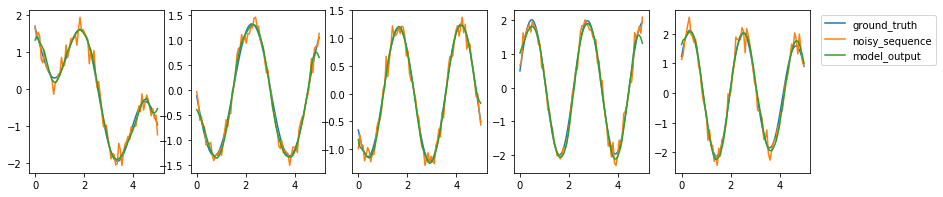

45.9484% of noise removed.
epoch: 71, train loss:6.522754669189453
epoch: 71, validation loss:43.516056060791016
epoch: 72, train loss:6.428261756896973
epoch: 72, validation loss:43.13948440551758
epoch: 73, train loss:6.287323474884033
epoch: 73, validation loss:42.23631286621094
epoch: 74, train loss:6.227492809295654
epoch: 74, validation loss:41.3735466003418
epoch: 75, train loss:6.193150997161865
epoch: 75, validation loss:40.892494201660156
epoch: 76, train loss:6.146552562713623
epoch: 76, validation loss:40.93564987182617
epoch: 77, train loss:6.108432769775391
epoch: 77, validation loss:41.44776916503906
epoch: 78, train loss:6.027302265167236
epoch: 78, validation loss:41.55115509033203
epoch: 79, train loss:5.962783336639404
epoch: 79, validation loss:40.9118766784668
epoch: 80, train loss:5.945023536682129
epoch: 80, validation loss:40.22787857055664


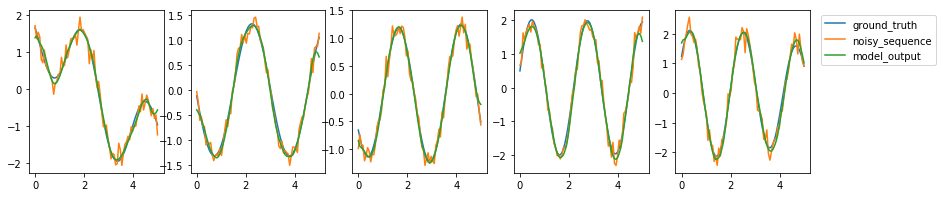

47.6559% of noise removed.
epoch: 81, train loss:5.9150519371032715
epoch: 81, validation loss:39.86406707763672
epoch: 82, train loss:5.865504741668701
epoch: 82, validation loss:39.88277053833008
epoch: 83, train loss:5.79423713684082
epoch: 83, validation loss:40.28874588012695
epoch: 84, train loss:5.726845741271973
epoch: 84, validation loss:40.20563888549805
epoch: 85, train loss:5.713890075683594
epoch: 85, validation loss:39.67416763305664
epoch: 86, train loss:5.688726902008057
epoch: 86, validation loss:39.30378341674805
epoch: 87, train loss:5.643115043640137
epoch: 87, validation loss:39.1306037902832
epoch: 88, train loss:5.59590482711792
epoch: 88, validation loss:39.38566970825195
epoch: 89, train loss:5.53351354598999
epoch: 89, validation loss:39.455963134765625
epoch: 90, train loss:5.518165111541748
epoch: 90, validation loss:39.09203338623047


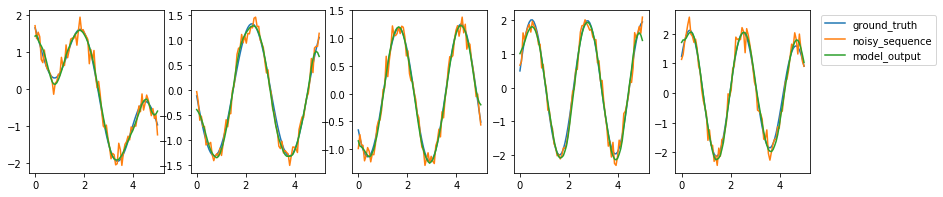

47.8576% of noise removed.
epoch: 91, train loss:5.478477954864502
epoch: 91, validation loss:38.77781295776367
epoch: 92, train loss:5.434835433959961
epoch: 92, validation loss:38.64449691772461
epoch: 93, train loss:5.399786949157715
epoch: 93, validation loss:38.83536148071289
epoch: 94, train loss:5.361950874328613
epoch: 94, validation loss:38.7947998046875
epoch: 95, train loss:5.334838390350342
epoch: 95, validation loss:38.55580139160156
epoch: 96, train loss:5.273493766784668
epoch: 96, validation loss:38.318485260009766
epoch: 97, train loss:5.235127925872803
epoch: 97, validation loss:38.31205749511719
epoch: 98, train loss:5.20759916305542
epoch: 98, validation loss:38.32283401489258
epoch: 99, train loss:5.181052207946777
epoch: 99, validation loss:38.216129302978516
epoch: 100, train loss:5.125436782836914
epoch: 100, validation loss:38.05409622192383


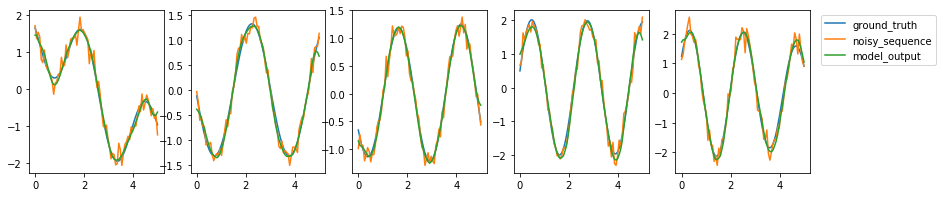

48.2096% of noise removed.
epoch: 101, train loss:5.0778093338012695
epoch: 101, validation loss:37.95804977416992
epoch: 102, train loss:5.047796249389648
epoch: 102, validation loss:37.890403747558594
epoch: 103, train loss:5.0173516273498535
epoch: 103, validation loss:37.82695007324219
epoch: 104, train loss:4.974667549133301
epoch: 104, validation loss:37.746150970458984
epoch: 105, train loss:4.944982051849365
epoch: 105, validation loss:37.65788269042969
epoch: 106, train loss:4.932199478149414
epoch: 106, validation loss:37.62038040161133
epoch: 107, train loss:4.92251443862915
epoch: 107, validation loss:37.61659622192383
epoch: 108, train loss:4.927535057067871
epoch: 108, validation loss:37.561302185058594
epoch: 109, train loss:4.964254379272461
epoch: 109, validation loss:37.5159912109375
epoch: 110, train loss:5.014922618865967
epoch: 110, validation loss:37.520782470703125


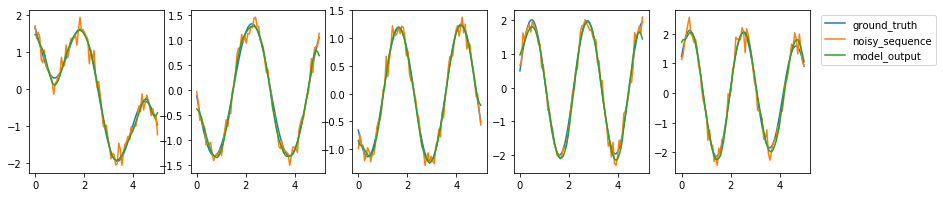

48.0409% of noise removed.
epoch: 111, train loss:5.055447578430176
epoch: 111, validation loss:37.521121978759766
epoch: 112, train loss:5.0591020584106445
epoch: 112, validation loss:37.537620544433594
epoch: 113, train loss:5.010216236114502
epoch: 113, validation loss:37.50694274902344
epoch: 114, train loss:4.942373275756836
epoch: 114, validation loss:37.384185791015625
epoch: 115, train loss:4.9016008377075195
epoch: 115, validation loss:37.29754638671875
epoch: 116, train loss:4.897266387939453
epoch: 116, validation loss:37.27300262451172
epoch: 117, train loss:4.903237342834473
epoch: 117, validation loss:37.285301208496094
epoch: 118, train loss:4.8837361335754395
epoch: 118, validation loss:37.291587829589844
epoch: 119, train loss:4.852237224578857
epoch: 119, validation loss:37.243228912353516
epoch: 120, train loss:4.840217113494873
epoch: 120, validation loss:37.20296859741211


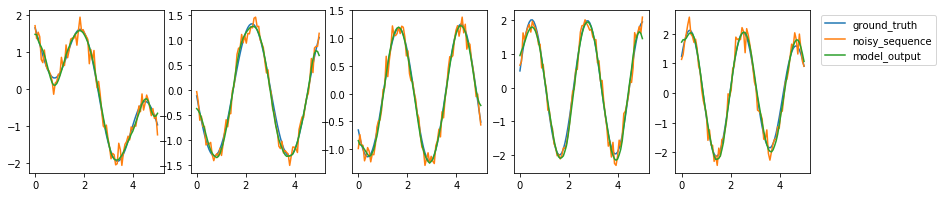

48.2995% of noise removed.
epoch: 121, train loss:4.836698055267334
epoch: 121, validation loss:37.18896484375
epoch: 122, train loss:4.819829940795898
epoch: 122, validation loss:37.16804885864258
epoch: 123, train loss:4.804681301116943
epoch: 123, validation loss:37.142372131347656
epoch: 124, train loss:4.79743766784668
epoch: 124, validation loss:37.13191604614258
epoch: 125, train loss:4.785024642944336
epoch: 125, validation loss:37.11362838745117
epoch: 126, train loss:4.775045871734619
epoch: 126, validation loss:37.096885681152344
epoch: 127, train loss:4.766402721405029
epoch: 127, validation loss:37.08468246459961
epoch: 128, train loss:4.756958484649658
epoch: 128, validation loss:37.07130432128906
epoch: 129, train loss:4.74931001663208
epoch: 129, validation loss:37.060611724853516
epoch: 130, train loss:4.741257667541504
epoch: 130, validation loss:37.04970932006836


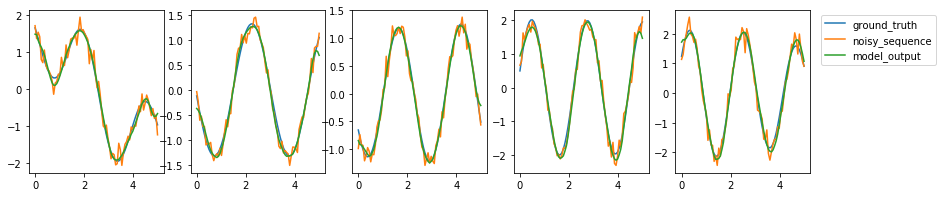

48.3675% of noise removed.
epoch: 131, train loss:4.734423637390137
epoch: 131, validation loss:37.04100799560547
epoch: 132, train loss:4.72768497467041
epoch: 132, validation loss:37.03238296508789
epoch: 133, train loss:4.721745014190674
epoch: 133, validation loss:37.025394439697266
epoch: 134, train loss:4.716123104095459
epoch: 134, validation loss:37.018985748291016
epoch: 135, train loss:4.711017608642578
epoch: 135, validation loss:37.01357650756836
epoch: 136, train loss:4.706376075744629
epoch: 136, validation loss:37.00892639160156
epoch: 137, train loss:4.702139377593994
epoch: 137, validation loss:37.004947662353516
epoch: 138, train loss:4.69834041595459
epoch: 138, validation loss:37.00168991088867
epoch: 139, train loss:4.694936752319336
epoch: 139, validation loss:36.99903869628906
epoch: 140, train loss:4.6919026374816895
epoch: 140, validation loss:36.996910095214844


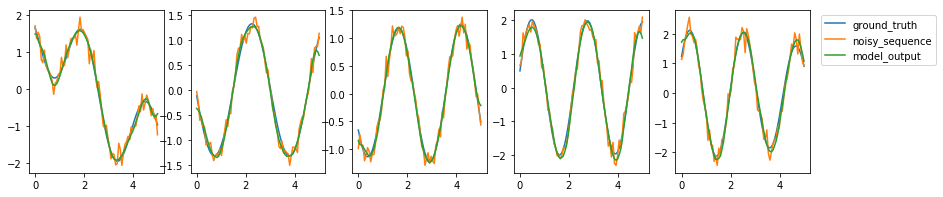

48.3923% of noise removed.
epoch: 141, train loss:4.689236640930176
epoch: 141, validation loss:36.99528121948242
epoch: 142, train loss:4.686909198760986
epoch: 142, validation loss:36.994075775146484
epoch: 143, train loss:4.684903144836426
epoch: 143, validation loss:36.99323654174805
epoch: 144, train loss:4.683199405670166
epoch: 144, validation loss:36.99267578125
epoch: 145, train loss:4.6817803382873535
epoch: 145, validation loss:36.992366790771484
epoch: 146, train loss:4.680624485015869
epoch: 146, validation loss:36.99221420288086
epoch: 147, train loss:4.679708957672119
epoch: 147, validation loss:36.99216842651367
epoch: 148, train loss:4.679018020629883
epoch: 148, validation loss:36.99216079711914
epoch: 149, train loss:4.678537368774414
epoch: 149, validation loss:36.99219512939453
epoch: 0, train loss:1317.0850830078125
epoch: 0, validation loss:2244.26025390625


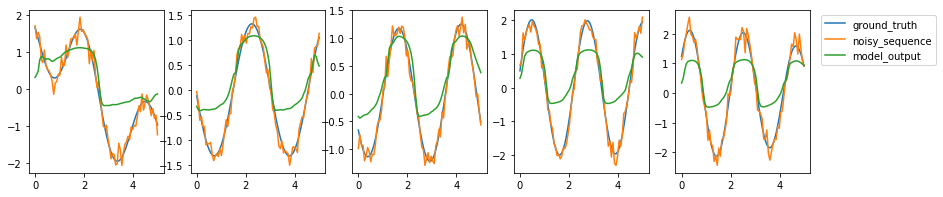

-312.9241% of noise removed.
epoch: 1, train loss:744.5745849609375
epoch: 1, validation loss:1857.80322265625
epoch: 2, train loss:326.37188720703125
epoch: 2, validation loss:945.1987915039062
epoch: 3, train loss:222.09823608398438
epoch: 3, validation loss:560.6477661132812
epoch: 4, train loss:108.6810073852539
epoch: 4, validation loss:474.676513671875
epoch: 5, train loss:74.4129409790039
epoch: 5, validation loss:405.73260498046875
epoch: 6, train loss:55.85288619995117
epoch: 6, validation loss:347.64788818359375
epoch: 7, train loss:68.32051086425781
epoch: 7, validation loss:196.41854858398438
epoch: 8, train loss:54.6709098815918
epoch: 8, validation loss:189.72743225097656
epoch: 9, train loss:30.295888900756836
epoch: 9, validation loss:178.47019958496094
epoch: 10, train loss:42.64570999145508
epoch: 10, validation loss:104.13432312011719


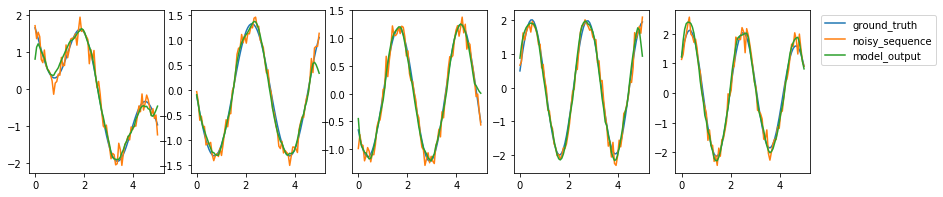

17.6493% of noise removed.
epoch: 11, train loss:42.718650817871094
epoch: 11, validation loss:132.51791381835938
epoch: 12, train loss:20.96999740600586
epoch: 12, validation loss:111.8887710571289
epoch: 13, train loss:27.609281539916992
epoch: 13, validation loss:78.90400695800781
epoch: 14, train loss:18.029367446899414
epoch: 14, validation loss:79.0200424194336
epoch: 15, train loss:22.734498977661133
epoch: 15, validation loss:66.89671325683594
epoch: 16, train loss:18.907882690429688
epoch: 16, validation loss:71.87425231933594
epoch: 17, train loss:16.911277770996094
epoch: 17, validation loss:57.863948822021484
epoch: 18, train loss:16.64877700805664
epoch: 18, validation loss:62.06548309326172
epoch: 19, train loss:15.880624771118164
epoch: 19, validation loss:66.35499572753906
epoch: 20, train loss:17.224536895751953
epoch: 20, validation loss:72.5062026977539


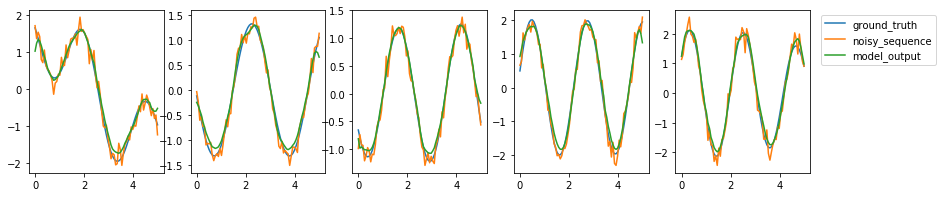

23.0503% of noise removed.
epoch: 21, train loss:18.701440811157227
epoch: 21, validation loss:103.11611938476562
epoch: 22, train loss:13.343430519104004
epoch: 22, validation loss:118.32955932617188
epoch: 23, train loss:15.31601333618164
epoch: 23, validation loss:75.31492614746094
epoch: 24, train loss:23.433563232421875
epoch: 24, validation loss:64.90780639648438
epoch: 25, train loss:15.868797302246094
epoch: 25, validation loss:87.38076782226562
epoch: 26, train loss:11.0152006149292
epoch: 26, validation loss:55.527076721191406
epoch: 27, train loss:12.895697593688965
epoch: 27, validation loss:50.393829345703125
epoch: 28, train loss:10.47296142578125
epoch: 28, validation loss:67.0018310546875
epoch: 29, train loss:12.184263229370117
epoch: 29, validation loss:49.790836334228516
epoch: 30, train loss:13.852917671203613
epoch: 30, validation loss:50.04155349731445


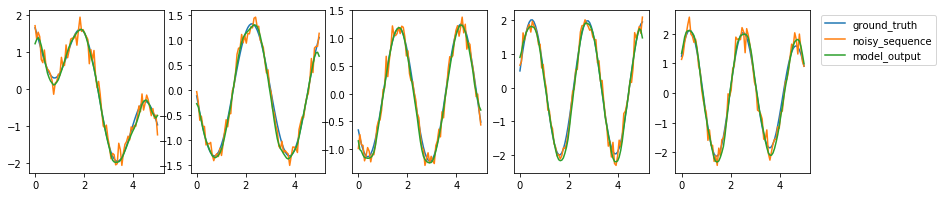

37.7147% of noise removed.
epoch: 31, train loss:12.71329402923584
epoch: 31, validation loss:60.17308807373047
epoch: 32, train loss:9.347723960876465
epoch: 32, validation loss:51.62757873535156
epoch: 33, train loss:8.618422508239746
epoch: 33, validation loss:52.91280746459961
epoch: 34, train loss:8.519081115722656
epoch: 34, validation loss:49.4300422668457
epoch: 35, train loss:9.451732635498047
epoch: 35, validation loss:47.15367889404297
epoch: 36, train loss:9.281097412109375
epoch: 36, validation loss:46.62278747558594
epoch: 37, train loss:9.318975448608398
epoch: 37, validation loss:44.51708221435547
epoch: 38, train loss:9.657000541687012
epoch: 38, validation loss:43.30968475341797
epoch: 39, train loss:9.407683372497559
epoch: 39, validation loss:48.608036041259766
epoch: 40, train loss:7.4263505935668945
epoch: 40, validation loss:44.156558990478516


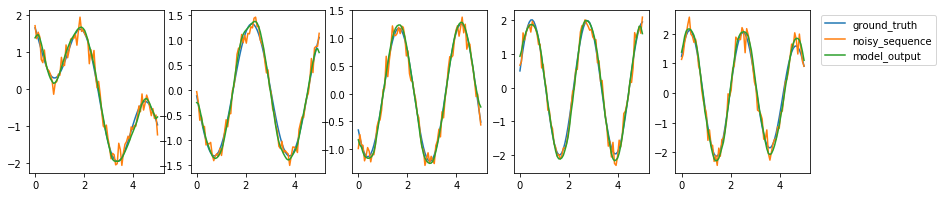

40.2073% of noise removed.
epoch: 41, train loss:7.274600982666016
epoch: 41, validation loss:43.419677734375
epoch: 42, train loss:7.12332010269165
epoch: 42, validation loss:44.3089485168457
epoch: 43, train loss:7.21411657333374
epoch: 43, validation loss:39.320796966552734
epoch: 44, train loss:6.202920913696289
epoch: 44, validation loss:39.07586669921875
epoch: 45, train loss:6.632046699523926
epoch: 45, validation loss:42.18017578125
epoch: 46, train loss:7.039992332458496
epoch: 46, validation loss:35.7784309387207
epoch: 47, train loss:8.436284065246582
epoch: 47, validation loss:39.671043395996094
epoch: 48, train loss:7.734372615814209
epoch: 48, validation loss:46.24007797241211
epoch: 49, train loss:6.515536308288574
epoch: 49, validation loss:42.73594284057617
epoch: 50, train loss:7.4878621101379395
epoch: 50, validation loss:38.1854248046875


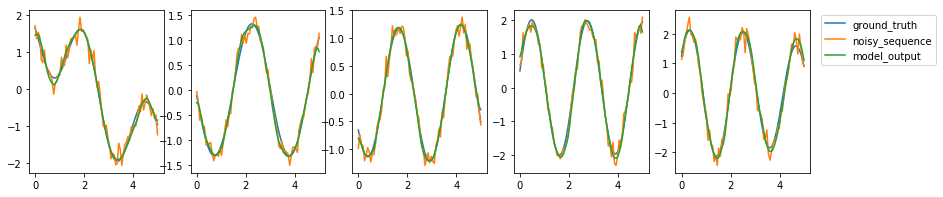

46.3640% of noise removed.
epoch: 51, train loss:9.09650993347168
epoch: 51, validation loss:43.72846221923828
epoch: 52, train loss:7.6513895988464355
epoch: 52, validation loss:45.90360641479492
epoch: 53, train loss:7.503394603729248
epoch: 53, validation loss:40.732765197753906
epoch: 54, train loss:11.837418556213379
epoch: 54, validation loss:40.66745376586914
epoch: 55, train loss:8.826054573059082
epoch: 55, validation loss:62.51802062988281
epoch: 56, train loss:13.165109634399414
epoch: 56, validation loss:47.11031723022461
epoch: 57, train loss:19.1680850982666
epoch: 57, validation loss:57.97847366333008
epoch: 58, train loss:11.094388008117676
epoch: 58, validation loss:66.16493225097656
epoch: 59, train loss:16.123550415039062
epoch: 59, validation loss:45.904361724853516
epoch: 60, train loss:10.443937301635742
epoch: 60, validation loss:50.245208740234375


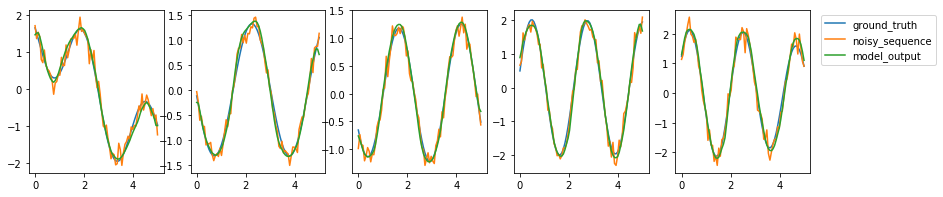

33.3653% of noise removed.
epoch: 61, train loss:12.53359603881836
epoch: 61, validation loss:45.383270263671875
epoch: 62, train loss:8.712687492370605
epoch: 62, validation loss:41.79644012451172
epoch: 63, train loss:7.255659580230713
epoch: 63, validation loss:42.25477981567383
epoch: 64, train loss:7.960263252258301
epoch: 64, validation loss:44.146728515625
epoch: 65, train loss:6.302251815795898
epoch: 65, validation loss:39.39057540893555
epoch: 66, train loss:7.002934455871582
epoch: 66, validation loss:39.25996398925781
epoch: 67, train loss:6.3938517570495605
epoch: 67, validation loss:38.75288009643555
epoch: 68, train loss:6.243123531341553
epoch: 68, validation loss:36.61271286010742
epoch: 69, train loss:6.642367839813232
epoch: 69, validation loss:38.220848083496094
epoch: 70, train loss:6.28628396987915
epoch: 70, validation loss:38.47993850708008


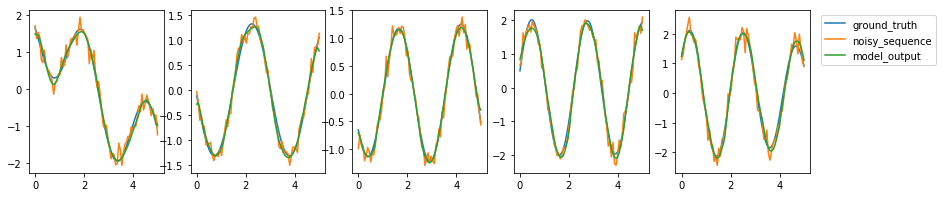

45.5535% of noise removed.
epoch: 71, train loss:5.615515232086182
epoch: 71, validation loss:35.25099563598633
epoch: 72, train loss:5.991592884063721
epoch: 72, validation loss:36.4459114074707
epoch: 73, train loss:5.492781639099121
epoch: 73, validation loss:36.388423919677734
epoch: 74, train loss:5.750833511352539
epoch: 74, validation loss:38.012813568115234
epoch: 75, train loss:5.552854061126709
epoch: 75, validation loss:34.93338394165039
epoch: 76, train loss:5.06649923324585
epoch: 76, validation loss:37.51392364501953
epoch: 77, train loss:5.423797130584717
epoch: 77, validation loss:36.216556549072266
epoch: 78, train loss:4.797621250152588
epoch: 78, validation loss:35.41846466064453
epoch: 79, train loss:5.380067825317383
epoch: 79, validation loss:36.26341247558594
epoch: 80, train loss:5.408933162689209
epoch: 80, validation loss:34.192543029785156


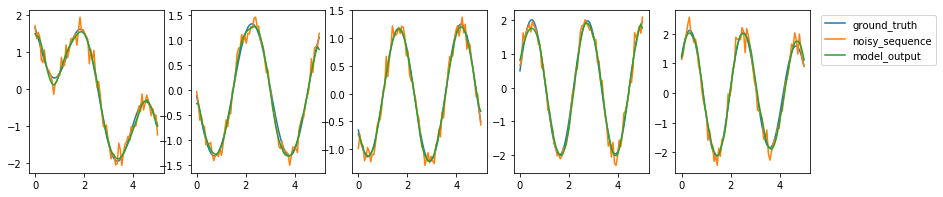

49.0189% of noise removed.
epoch: 81, train loss:5.387279510498047
epoch: 81, validation loss:33.469764709472656
epoch: 82, train loss:6.272123336791992
epoch: 82, validation loss:35.80278015136719
epoch: 83, train loss:6.4501214027404785
epoch: 83, validation loss:37.905029296875
epoch: 84, train loss:7.330066204071045
epoch: 84, validation loss:42.0751838684082
epoch: 85, train loss:6.1400957107543945
epoch: 85, validation loss:45.29350662231445
epoch: 86, train loss:4.9322075843811035
epoch: 86, validation loss:42.16656494140625
epoch: 87, train loss:5.250516891479492
epoch: 87, validation loss:38.019813537597656
epoch: 88, train loss:5.558486461639404
epoch: 88, validation loss:36.001285552978516
epoch: 89, train loss:5.769189357757568
epoch: 89, validation loss:43.07615280151367
epoch: 90, train loss:4.796131610870361
epoch: 90, validation loss:41.31721115112305


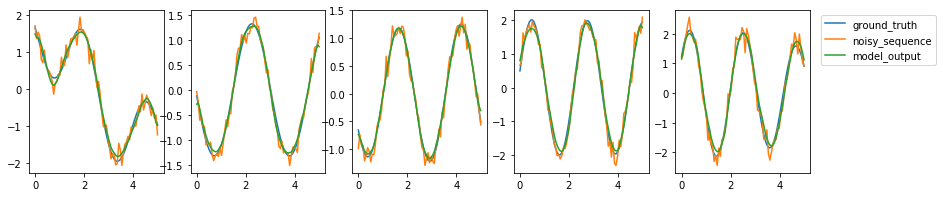

42.1354% of noise removed.
epoch: 91, train loss:5.519444465637207
epoch: 91, validation loss:34.04219055175781
epoch: 92, train loss:6.4159345626831055
epoch: 92, validation loss:39.54209899902344
epoch: 93, train loss:5.168211460113525
epoch: 93, validation loss:40.306182861328125
epoch: 94, train loss:4.7380194664001465
epoch: 94, validation loss:35.09797286987305
epoch: 95, train loss:5.025400161743164
epoch: 95, validation loss:35.933834075927734
epoch: 96, train loss:4.353277206420898
epoch: 96, validation loss:36.696388244628906
epoch: 97, train loss:4.99402379989624
epoch: 97, validation loss:35.3454704284668
epoch: 98, train loss:5.235335826873779
epoch: 98, validation loss:36.295448303222656
epoch: 99, train loss:4.39053201675415
epoch: 99, validation loss:35.236419677734375
epoch: 100, train loss:4.494139671325684
epoch: 100, validation loss:34.43543243408203


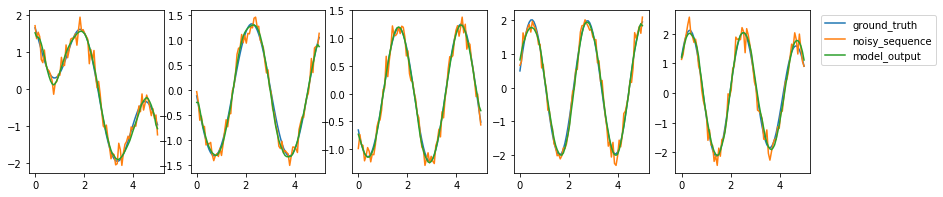

49.5352% of noise removed.
epoch: 101, train loss:4.126547813415527
epoch: 101, validation loss:35.576904296875
epoch: 102, train loss:4.2789812088012695
epoch: 102, validation loss:34.97113800048828
epoch: 103, train loss:4.4214677810668945
epoch: 103, validation loss:34.3033447265625
epoch: 104, train loss:4.325325965881348
epoch: 104, validation loss:35.11041259765625
epoch: 105, train loss:4.141118049621582
epoch: 105, validation loss:35.28462219238281
epoch: 106, train loss:4.097189426422119
epoch: 106, validation loss:34.81526184082031
epoch: 107, train loss:4.039370059967041
epoch: 107, validation loss:34.86748504638672
epoch: 108, train loss:4.2423834800720215
epoch: 108, validation loss:34.62495422363281
epoch: 109, train loss:4.100383281707764
epoch: 109, validation loss:35.25852584838867
epoch: 110, train loss:4.092293739318848
epoch: 110, validation loss:35.0777702331543


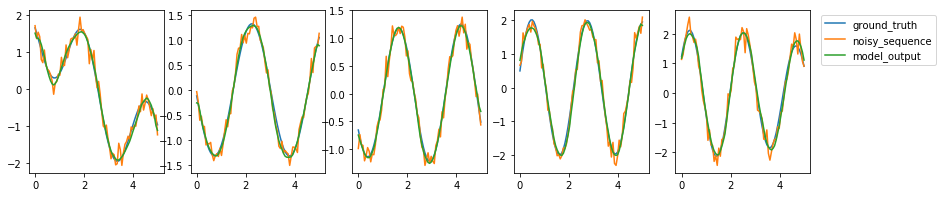

49.4149% of noise removed.
epoch: 111, train loss:3.899036169052124
epoch: 111, validation loss:34.64485549926758
epoch: 112, train loss:4.028957366943359
epoch: 112, validation loss:35.16085433959961
epoch: 113, train loss:4.022254943847656
epoch: 113, validation loss:34.95979309082031
epoch: 114, train loss:3.9036202430725098
epoch: 114, validation loss:34.8282585144043
epoch: 115, train loss:3.864556312561035
epoch: 115, validation loss:34.913177490234375
epoch: 116, train loss:3.8340189456939697
epoch: 116, validation loss:34.97614669799805
epoch: 117, train loss:3.9397411346435547
epoch: 117, validation loss:35.207611083984375
epoch: 118, train loss:3.7923192977905273
epoch: 118, validation loss:34.9415397644043
epoch: 119, train loss:3.760699987411499
epoch: 119, validation loss:35.057159423828125
epoch: 120, train loss:3.7981183528900146
epoch: 120, validation loss:35.18966293334961


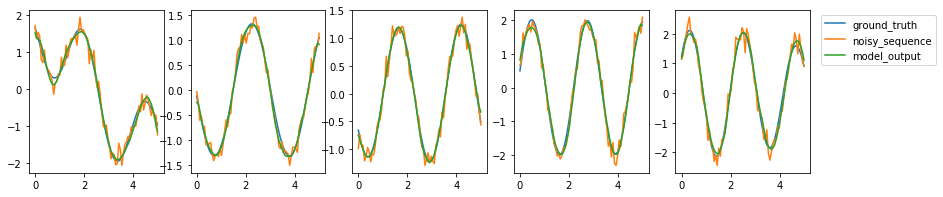

49.4405% of noise removed.
epoch: 121, train loss:3.7828662395477295
epoch: 121, validation loss:35.09083938598633
epoch: 122, train loss:3.7496156692504883
epoch: 122, validation loss:35.244571685791016
epoch: 123, train loss:3.697559118270874
epoch: 123, validation loss:35.23786926269531
epoch: 124, train loss:3.705470323562622
epoch: 124, validation loss:35.39971923828125
epoch: 125, train loss:3.721479892730713
epoch: 125, validation loss:35.27513885498047
epoch: 126, train loss:3.6773173809051514
epoch: 126, validation loss:35.40105056762695
epoch: 127, train loss:3.6492555141448975
epoch: 127, validation loss:35.53803634643555
epoch: 128, train loss:3.645566701889038
epoch: 128, validation loss:35.496028900146484
epoch: 129, train loss:3.660175085067749
epoch: 129, validation loss:35.51930618286133
epoch: 130, train loss:3.6239051818847656
epoch: 130, validation loss:35.65297317504883


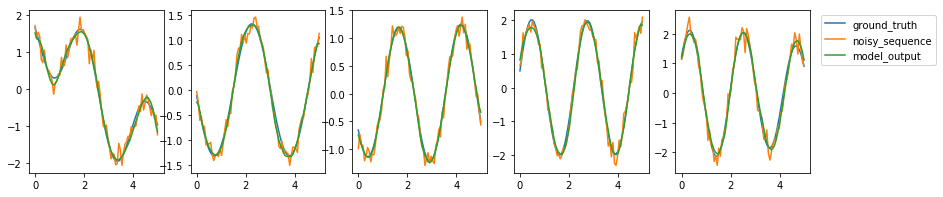

49.3829% of noise removed.
epoch: 131, train loss:3.591817855834961
epoch: 131, validation loss:35.669410705566406
epoch: 132, train loss:3.606743574142456
epoch: 132, validation loss:35.68461227416992
epoch: 133, train loss:3.601623296737671
epoch: 133, validation loss:35.7792854309082
epoch: 134, train loss:3.564755439758301
epoch: 134, validation loss:35.82756423950195
epoch: 135, train loss:3.556490898132324
epoch: 135, validation loss:35.82360076904297
epoch: 136, train loss:3.5632166862487793
epoch: 136, validation loss:35.91041946411133
epoch: 137, train loss:3.540295124053955
epoch: 137, validation loss:35.972869873046875
epoch: 138, train loss:3.526402235031128
epoch: 138, validation loss:35.9870491027832
epoch: 139, train loss:3.5228912830352783
epoch: 139, validation loss:36.01969528198242
epoch: 140, train loss:3.510678291320801
epoch: 140, validation loss:36.098995208740234


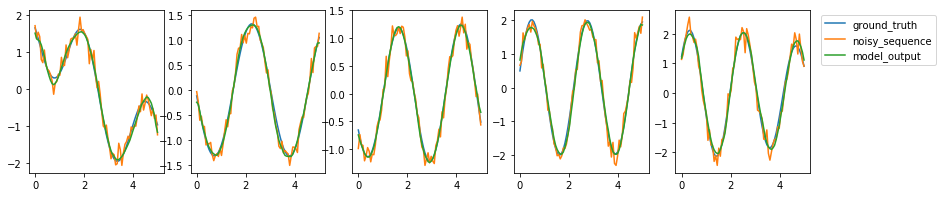

49.1977% of noise removed.
epoch: 141, train loss:3.5002458095550537
epoch: 141, validation loss:36.13200759887695
epoch: 142, train loss:3.4919798374176025
epoch: 142, validation loss:36.14521789550781
epoch: 143, train loss:3.48075532913208
epoch: 143, validation loss:36.20552444458008
epoch: 144, train loss:3.4736790657043457
epoch: 144, validation loss:36.243438720703125
epoch: 145, train loss:3.464625120162964
epoch: 145, validation loss:36.26188659667969
epoch: 146, train loss:3.4544589519500732
epoch: 146, validation loss:36.30634689331055
epoch: 147, train loss:3.448212146759033
epoch: 147, validation loss:36.33068084716797
epoch: 148, train loss:3.4392077922821045
epoch: 148, validation loss:36.36153030395508
epoch: 149, train loss:3.431161642074585
epoch: 149, validation loss:36.38665008544922
epoch: 150, train loss:3.4239983558654785
epoch: 150, validation loss:36.41289520263672


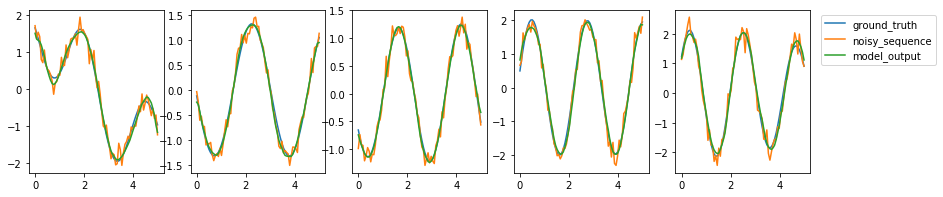

49.0811% of noise removed.
epoch: 151, train loss:3.4164321422576904
epoch: 151, validation loss:36.438507080078125
epoch: 152, train loss:3.4096081256866455
epoch: 152, validation loss:36.45846176147461
epoch: 153, train loss:3.402243137359619
epoch: 153, validation loss:36.483154296875
epoch: 154, train loss:3.3959858417510986
epoch: 154, validation loss:36.502628326416016
epoch: 155, train loss:3.389209508895874
epoch: 155, validation loss:36.52337646484375
epoch: 156, train loss:3.383329153060913
epoch: 156, validation loss:36.5425910949707
epoch: 157, train loss:3.377065658569336
epoch: 157, validation loss:36.561073303222656
epoch: 158, train loss:3.3714120388031006
epoch: 158, validation loss:36.57906723022461
epoch: 159, train loss:3.3657712936401367
epoch: 159, validation loss:36.59620666503906
epoch: 160, train loss:3.3604698181152344
epoch: 160, validation loss:36.6125373840332


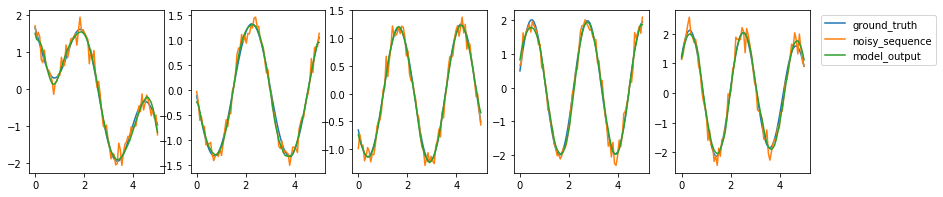

49.0000% of noise removed.
epoch: 161, train loss:3.3552987575531006
epoch: 161, validation loss:36.62865447998047
epoch: 162, train loss:3.3503711223602295
epoch: 162, validation loss:36.64369583129883
epoch: 163, train loss:3.345602512359619
epoch: 163, validation loss:36.658329010009766
epoch: 164, train loss:3.341073513031006
epoch: 164, validation loss:36.67229461669922
epoch: 165, train loss:3.3367409706115723
epoch: 165, validation loss:36.68570327758789
epoch: 166, train loss:3.332569122314453
epoch: 166, validation loss:36.698448181152344
epoch: 167, train loss:3.328622579574585
epoch: 167, validation loss:36.71063232421875
epoch: 168, train loss:3.3248307704925537
epoch: 168, validation loss:36.72224044799805
epoch: 169, train loss:3.3212380409240723
epoch: 169, validation loss:36.73322677612305
epoch: 170, train loss:3.317821979522705
epoch: 170, validation loss:36.743690490722656


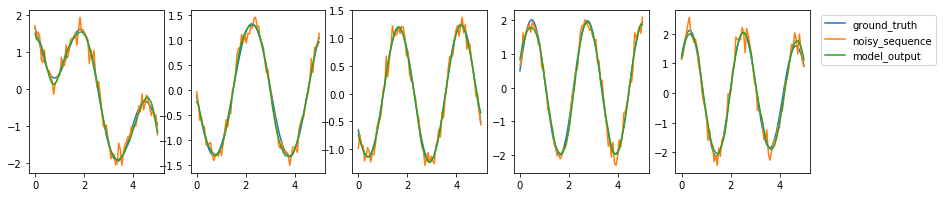

48.9452% of noise removed.
epoch: 171, train loss:3.31457781791687
epoch: 171, validation loss:36.75359344482422
epoch: 172, train loss:3.3115103244781494
epoch: 172, validation loss:36.76292419433594
epoch: 173, train loss:3.3086037635803223
epoch: 173, validation loss:36.771732330322266
epoch: 174, train loss:3.305863380432129
epoch: 174, validation loss:36.77996826171875
epoch: 175, train loss:3.3032867908477783
epoch: 175, validation loss:36.78771209716797
epoch: 176, train loss:3.30086088180542
epoch: 176, validation loss:36.79494094848633
epoch: 177, train loss:3.2985892295837402
epoch: 177, validation loss:36.801658630371094
epoch: 178, train loss:3.2964649200439453
epoch: 178, validation loss:36.807891845703125
epoch: 179, train loss:3.294485330581665
epoch: 179, validation loss:36.81364059448242
epoch: 180, train loss:3.2926442623138428
epoch: 180, validation loss:36.81893539428711


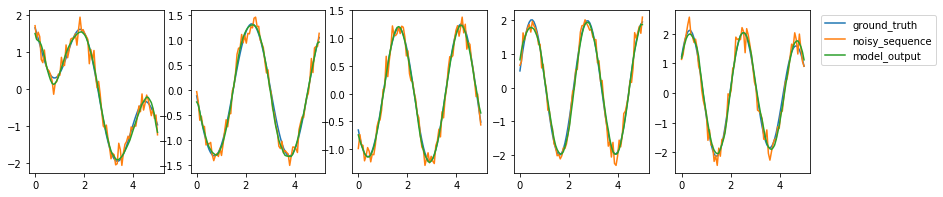

48.9131% of noise removed.
epoch: 181, train loss:3.290937900543213
epoch: 181, validation loss:36.82377624511719
epoch: 182, train loss:3.2893640995025635
epoch: 182, validation loss:36.828182220458984
epoch: 183, train loss:3.2879161834716797
epoch: 183, validation loss:36.832157135009766
epoch: 184, train loss:3.286588191986084
epoch: 184, validation loss:36.835750579833984
epoch: 185, train loss:3.2853786945343018
epoch: 185, validation loss:36.83894348144531
epoch: 186, train loss:3.284282922744751
epoch: 186, validation loss:36.841766357421875
epoch: 187, train loss:3.283294677734375
epoch: 187, validation loss:36.844242095947266
epoch: 188, train loss:3.282407760620117
epoch: 188, validation loss:36.84638595581055
epoch: 189, train loss:3.281621217727661
epoch: 189, validation loss:36.84821319580078
epoch: 190, train loss:3.2809269428253174
epoch: 190, validation loss:36.84976577758789


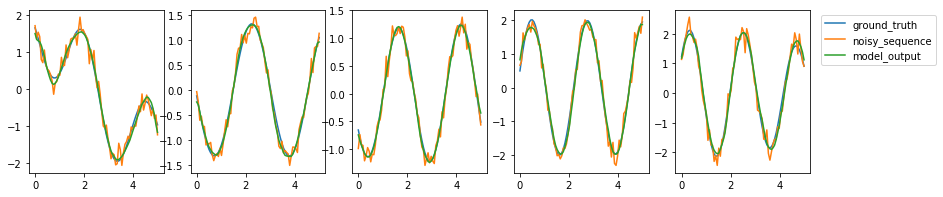

48.9014% of noise removed.
epoch: 191, train loss:3.280320882797241
epoch: 191, validation loss:36.85103988647461
epoch: 192, train loss:3.2797977924346924
epoch: 192, validation loss:36.852073669433594
epoch: 193, train loss:3.279352903366089
epoch: 193, validation loss:36.852882385253906
epoch: 194, train loss:3.2789785861968994
epoch: 194, validation loss:36.8535041809082
epoch: 195, train loss:3.2786734104156494
epoch: 195, validation loss:36.85395431518555
epoch: 196, train loss:3.2784276008605957
epoch: 196, validation loss:36.854270935058594
epoch: 197, train loss:3.2782399654388428
epoch: 197, validation loss:36.854461669921875
epoch: 198, train loss:3.278102397918701
epoch: 198, validation loss:36.85457229614258
epoch: 199, train loss:3.2780120372772217
epoch: 199, validation loss:36.85462951660156


In [11]:
# don't forget to create a new model each time!
# START TODO #############

# Configuration 1
batch_size = 20
num_epochs = 101
model = NoiseRemovalModel(hidden_size=40, shift=5)
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)

# Configuration 2
batch_size = 10
num_epochs = 150
model = NoiseRemovalModel(hidden_size=30, shift=7)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)

# Configuration 3
batch_size = 15
num_epochs = 200
model = NoiseRemovalModel(hidden_size=50, shift=5)
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)



**FEEDBACK**

- Time spent: 1 - 2 h
- Useful: yes, it is impressive to se LSTM be able to denoise the signal up to a certain degree
- Major problems: none

This part is a better test to see if our implementation of LSTM is working properly. We managed to get the 97% in the first part even with a wrong implementation. But once we reached this part, we were sure it was wrong.
